<a href="https://colab.research.google.com/github/kuotuantuan/Fraud-Detection/blob/main/Random%20Forest/ethereum-fraud-detection-eda-model-selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This dataset contains rows of known fraud and valid transactions made over Ethereum.



### Task: EDA & Prediction of Fraud/Valid Transaction

Here is a description of the rows of the dataset:
* Index: the index number of a row
* Address: the address of the ethereum account
* FLAG: whether the transaction is fraud or not
* Avg min between sent tnx: Average time between sent transactions for account in minutes
* Avgminbetweenreceivedtnx: Average time between received transactions for account in minutes
* TimeDiffbetweenfirstand_last(Mins): Time difference between the first and last transaction
* Sent_tnx: Total number of sent normal transactions
* Received_tnx: Total number of received normal transactions
* NumberofCreated_Contracts: Total Number of created contract transactions
* UniqueReceivedFrom_Addresses: Total Unique addresses from which account received transactions
* UniqueSentTo_Addresses20: Total Unique addresses from which account sent transactions
* MinValueReceived: Minimum value in Ether ever received
* MaxValueReceived: Maximum value in Ether ever received
* AvgValueReceived5Average value in Ether ever received
* MinValSent: Minimum value of Ether ever sent
* MaxValSent: Maximum value of Ether ever sent
* AvgValSent: Average value of Ether ever sent
* MinValueSentToContract: Minimum value of Ether sent to a contract
* MaxValueSentToContract: Maximum value of Ether sent to a contract
* AvgValueSentToContract: Average value of Ether sent to contracts
* TotalTransactions(IncludingTnxtoCreate_Contract): Total number of transactions
* TotalEtherSent:Total Ether sent for account address
* TotalEtherReceived: Total Ether received for account address
* TotalEtherSent_Contracts: Total Ether sent to Contract addresses
* TotalEtherBalance: Total Ether Balance following enacted transactions
* TotalERC20Tnxs: Total number of ERC20 token transfer transactions
* ERC20TotalEther_Received: Total ERC20 token received transactions in Ether
* ERC20TotalEther_Sent: Total ERC20token sent transactions in Ether
* ERC20TotalEtherSentContract: Total ERC20 token transfer to other contracts in Ether
* ERC20UniqSent_Addr: Number of ERC20 token transactions sent to Unique account addresses
* ERC20UniqRec_Addr: Number of ERC20 token transactions received from Unique addresses
* ERC20UniqRecContractAddr: Number of ERC20token transactions received from Unique contract addresses
* ERC20AvgTimeBetweenSent_Tnx: Average time between ERC20 token sent transactions in minutes
* ERC20AvgTimeBetweenRec_Tnx: Average time between ERC20 token received transactions in minutes
* ERC20AvgTimeBetweenContract_Tnx: Average time ERC20 token between sent token transactions
* ERC20MinVal_Rec: Minimum value in Ether received from ERC20 token transactions for account
* ERC20MaxVal_Rec: Maximum value in Ether received from ERC20 token transactions for account
* ERC20AvgVal_Rec: Average value in Ether received from ERC20 token transactions for account
* ERC20MinVal_Sent: Minimum value in Ether sent from ERC20 token transactions for account
* ERC20MaxVal_Sent: Maximum value in Ether sent from ERC20 token transactions for account
* ERC20AvgVal_Sent: Average value in Ether sent from ERC20 token transactions for account
* ERC20UniqSentTokenName: Number of Unique ERC20 tokens transferred
* ERC20UniqRecTokenName: Number of Unique ERC20 tokens received
* ERC20MostSentTokenType: Most sent token for account via ERC20 transaction
* ERC20MostRecTokenType: Most received token for account via ERC20 transactions

## Code start

### Data Input and Description

In [24]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import klib

from sklearn.model_selection import StratifiedKFold, cross_validate, learning_curve, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, plot_confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
import lightgbm as lgb

import os

In [25]:
df = pd.read_csv('/content/transaction_dataset.csv', index_col=[0])
df.drop(columns='Index', inplace=True)
df.drop_duplicates(inplace=True)

In [26]:
# sampling some observations
print(df.shape)
# df.sample(3)

(9823, 49)


In [27]:
# column names
# display(df.columns)

# describtion of numeratic columns
# display(df.describe())

# Non-Null Count and type of columns
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9823 entries, 0 to 9840
Data columns (total 49 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Address                                               9823 non-null   object 
 1   FLAG                                                  9823 non-null   int64  
 2   Avg min between sent tnx                              9823 non-null   float64
 3   Avg min between received tnx                          9823 non-null   float64
 4   Time Diff between first and last (Mins)               9823 non-null   float64
 5   Sent tnx                                              9823 non-null   int64  
 6   Received Tnx                                          9823 non-null   int64  
 7   Number of Created Contracts                           9823 non-null   int64  
 8   Unique Received From Addresses                        9823

None

In [28]:
zero_feature_list = df.columns[(df.nunique() == 1)].tolist()
zero_feature_list

[' ERC20 avg time between sent tnx',
 ' ERC20 avg time between rec tnx',
 ' ERC20 avg time between rec 2 tnx',
 ' ERC20 avg time between contract tnx',
 ' ERC20 min val sent contract',
 ' ERC20 max val sent contract',
 ' ERC20 avg val sent contract']

### Categorical columns

#### Check Address

In [34]:
# non-unique adresses
_, uniq_idx, counts = np.unique(df['Address'].to_numpy(), return_index=True, return_counts=True)
non_unique_addresses_idx = uniq_idx[counts > 1]
print("non-unique adresses count: {}".format(len(non_unique_addresses_idx), end='\n\n'))
# The flags of non-uniqe adresses
non_unique_addresses_flags = df.iloc[non_unique_addresses_idx]['FLAG']
print("flags of non-unique adresses: ", end='')
print(*non_unique_addresses_flags)

non-unique adresses count: 7
flags of non-unique adresses: 0 0 0 0 0 0 0


In [37]:
df['Non_unique_Address'] = 0
df.loc[non_unique_addresses_idx, 'Non_unique_Address'] = 1

In [43]:
feature_list = list(set(df.columns) - set(['Address', 'FLAG']) - set(zero_feature_list))
num_feature_list = list(set(feature_list) - set(df.dtypes[df.dtypes == 'object'].index) - set(zero_feature_list))
cat_feature_list = list(set(feature_list) - set(num_feature_list))

assert len(feature_list) == len(num_feature_list) + len(cat_feature_list)

In [45]:
cat_feature_list

[' ERC20 most sent token type', ' ERC20_most_rec_token_type']

### Numerical columns

In [41]:
# are classes balanced?
print('class : count : percent')
print('0     : {}  : {:.2%}'.format(sum(df['FLAG']==0), sum(df['FLAG']==0)/len(df['FLAG']) ))
print('1     : {}  : {:.2%}'.format(sum(df['FLAG']==1), sum(df['FLAG']==1)/len(df['FLAG']) ))

class : count : percent
0     : 7644  : 77.82%
1     : 2179  : 22.18%


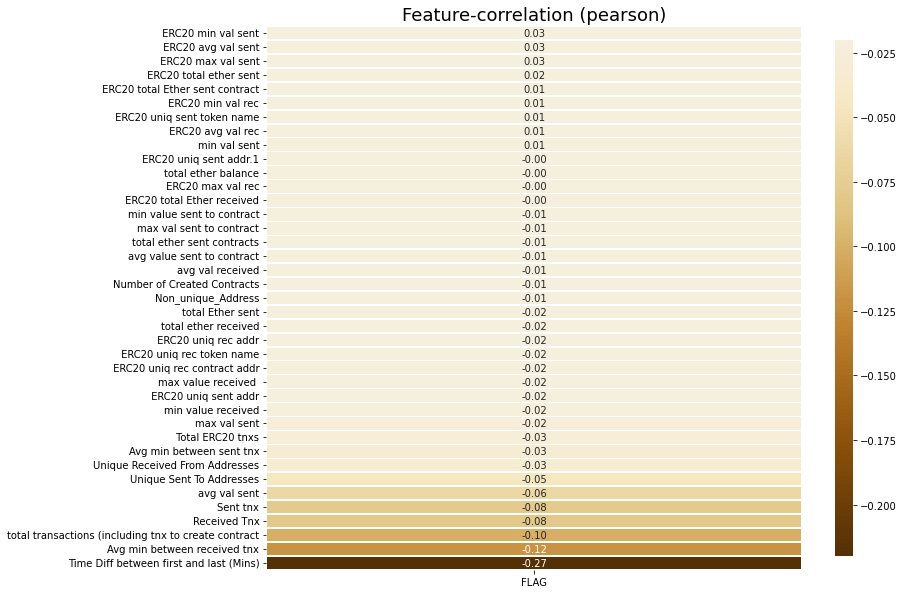

In [44]:
# find the correlation with all other numeric variables in the raw data set
klib.corr_plot(df[num_feature_list+['FLAG']], target='FLAG')

Dataset is unbalanced, we must remember about this when choosing our model metric.

### Missing Values

In [ ]:
# missing values
missing_values = ds.isna()
missing_percent = missing_values.sum() / ds.shape[0] * 100
missing_df = pd.DataFrame([missing_values.sum(), missing_percent], ['count', 'percent'])
display(missing_df.sort_values(by='percent', axis=1, ascending=False))
missing_df.sort_values(by='percent', axis=1, ascending=False).to_csv('missing.csv')

sns.heatmap(missing_values, cbar=False, cmap='magma')
plt.show()

Looks like missing values are highly connected to fraud cases

In [ ]:
non_fraud_rows, fraud_rows = np.where( [ds.iloc[:,0]==1] )
print(ds.iloc[fraud_rows,:].isna().sum()[-20:])

As we expected every missing value is in fraud rows. That means that almost 40% of fraud rows have missing values.

In [ ]:
missing_columns = ds.columns[ds.isna().sum() > 0]

In [ ]:
# correlation
corr = ds.corr()
plt.figure(figsize=(20,12))
sns.heatmap(np.abs(corr), cmap='coolwarm')
plt.show()

## Data preprocessing

We left only numeratic features so preprocessing is limited to imputing null values with column mean and scaling.

In [ ]:
preprocessing_pipeline = Pipeline([
    ('impoter', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

X = ds.drop(columns='FLAG').to_numpy()
y = ds['FLAG'].to_numpy()

random_permutation = np.random.permutation(len(X))
X = X[random_permutation]
y = y[random_permutation]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

X_train = preprocessing_pipeline.fit_transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

## Model selection

In [ ]:
def evaluate_models(X, y, models, cv):
    f1_scores = dict()
    acc_scores = dict()
    
    for i, model in enumerate(models):
        clf_pipeline = make_pipeline(preprocessing_pipeline, model)
        results = cross_validate(clf_pipeline, X, y, cv=cv, scoring=['f1', 'accuracy'], n_jobs=-1)
        avg_f1 = np.mean(results['test_f1'])
        avg_acc = np.mean(results['test_accuracy'])
        
        model_name = model.__class__.__name__
        f1_scores[model_name] = avg_f1
        acc_scores[model_name] = avg_acc
        print('{}-of-{}: {} f1={}, acc={}'.format(i+1, len(models), model_name, avg_f1, avg_acc))
    return f1_scores, acc_scores

In [ ]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)

classifiers = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    lgb.LGBMClassifier(random_state=42),
    xgb.XGBClassifier(random_state=42),
    SVC(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    MLPClassifier(random_state=42),
]

In [ ]:
f1_scores, acc_scores = evaluate_models(X, y, classifiers, cv)

In [ ]:
def visualize_scores(f1_scores, acc_scores):
    x = np.arange(len(f1_scores))
    width = 0.45
    
    f1_values = list(f1_scores.values())
    acc_values = list(acc_scores.values())
    
    plt.figure(figsize=(15, 8)).tight_layout()
    plt.bar(x - width / 2, f1_values, width, label='f1')
    plt.bar(x + width / 2, acc_values, width, label='accuracy')
    
    for index, value in enumerate(x - width / 2):
        plt.text(value, f1_values[index], '{:.3}'.format(f1_values[index]),
                 verticalalignment='bottom', horizontalalignment='center', fontsize=10)

    for index, value in enumerate(x + width / 2):
        plt.text(value, acc_values[index], '{:.3}'.format(acc_values[index]),
                 verticalalignment='bottom', horizontalalignment='center', fontsize=10)    
    
    classifiers_names = f1_scores.keys()
    plt.xticks(x, classifiers_names, rotation=40, horizontalalignment='right', fontsize=10)
    plt.legend()

visualize_scores(f1_scores, acc_scores)

### XGBClassifier hyperparameter tuning

In [ ]:
xgb_parameters = {
    'xgbclassifier__n_estimators': range(1000, 4001, 1000),
    'xgbclassifier__gamma': [0, 0.5, 1],
    'xgbclassifier__max_depth': [5, 6, 7]
}

xgb_pipeline = make_pipeline(preprocessing_pipeline, xgb.XGBClassifier(random_state=42))
# xgb_pipeline.steps
xgb_grid_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_parameters,
    scoring = 'f1',
    n_iter = 12,
    n_jobs = -1,
    cv = 5,
    random_state=42
)

xgb_grid_search.fit(X, y)

In [ ]:
#grid_search.grid_scores_
display(xgb_grid_search.best_score_)
display(xgb_grid_search.best_params_)

In [ ]:
LGBM_parameters = {
        'lgbmclassifier__bagging_fraction': [0, 0.2, 0.5, 0.8, 1],
        'lgbmclassifier__feature_fraction': [0.5, 0.8],
        'lgbmclassifier__max_depth': [6, 10, 13, 16, 20],
        'lgbmclassifier__min_data_in_leaf': range(40, 180, 20),
        'lgbmclassifier__num_leaves': range(500, 2500, 300)
}

LGBM_pipeline = make_pipeline(preprocessing_pipeline, lgb.LGBMClassifier(random_state=42))
LGBM_grid_search = RandomizedSearchCV(
    LGBM_pipeline,
    param_distributions=LGBM_parameters,
    scoring = 'f1',
    n_iter = 60,
    n_jobs = -1,
    cv = 5,
    random_state=42
)

LGBM_grid_search.fit(X, y)

In [ ]:
display(LGBM_grid_search.best_score_)
display(LGBM_grid_search.best_params_)

In [ ]:
RFC_parameters = {
        'randomforestclassifier__n_estimators': range(50, 1050, 100),
        'randomforestclassifier__max_depth': range(50, 300, 20),
        'randomforestclassifier__min_samples_split': [2, 5, 10],
        'randomforestclassifier__min_samples_leaf': [1, 2, 4],
        'randomforestclassifier__bootstrap': [True, False]
}

RFC_pipeline = make_pipeline(preprocessing_pipeline, RandomForestClassifier(random_state=42))
RFC_grid_search = RandomizedSearchCV(
    RFC_pipeline,
    param_distributions=RFC_parameters,
    scoring = 'f1',
    n_iter = 24,
    n_jobs = -1,
    cv = 5,
    random_state=42
)

RFC_grid_search.fit(X, y)

In [ ]:
display(RFC_grid_search.best_score_)
display(RFC_grid_search.best_params_)

## Best model evaluation

In [ ]:
best_model = lgb.LGBMClassifier(num_leaves=1400, min_data_in_leaf=100, max_depth=10,
    feature_fraction=0.8, bagging_fraction=0.5, random_state=42)

best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)

In [ ]:
print("f1 score = {}".format(f1_score(y_test, predictions)))

print("ROC AUC score = {}".format(roc_auc_score(y_test, predictions)))

print("accuracy score = {}".format(accuracy_score(y_test, predictions)))

display(plot_confusion_matrix(best_model, X_test, y_test))

In [ ]:
def plot_features_importance(feature_importance):
    column_names = ds.drop(columns='FLAG').columns

    df_feature_importance = pd.DataFrame(sorted(zip(feature_importance, column_names)),
                                       columns=['Importance value', 'Feature'])
    df_feature_importance = df_feature_importance.sort_values('Importance value', ascending=False)

    plt.figure(figsize=(9, 7)).tight_layout()
    sns.barplot(y="Feature", x="Importance value", data=df_feature_importance)
    plt.show()

plot_features_importance(best_model.feature_importances_)